<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Fabrice Jimenez | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

# Dimensionality Reduction - Practical Application

This notebook is following the progression of the Dimensionality Reduction class. It provides practical illustrations in Python  to understand the notions we have seen in this course.

<div class="alert alert-warning">
Author: Fabrice JIMENEZ
    
Link to course materials: https://github.com/SupaeroDataScience/deep-learning/tree/main/DR
</div>

## Preliminary loading with Google Colab

If you are using this notebook with Google Colab, please execute first the following cells, to retrieve the GitHub repository content. Otherwise, ignore these cells and move to the next section.

In [ ]:
# import os
# os.mkdir('data')

In [ ]:
# !wget -c https://github.com/SupaeroDataScience/deep-learning/blob/main/DR/data/mnist_test.csv?raw=true -O data/mnist_test.csv


## Imports and Loading Dataset

The dataset we will use for this application is the famous MNIST dataset (handwritten digits). We use the CSV version of this dataset available here: https://pjreddie.com/projects/mnist-in-csv/ 

We will keep only the mnist_test.csv file, containing 10 000 gray-scale images of dimension 28 x 28.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/mnist_test.csv', header=None)
df['pixels'] = df.index.map(lambda x: np.array(df.iloc[x][1:]))
dropcols = df.columns[(df.columns != 0) * (df.columns != 'pixels')]
df.drop(dropcols, axis=1, inplace=True)
df.columns = ['label','pixels']
print(df.shape)

(10000, 2)


In [3]:
df.head()

,label,pixels
0,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


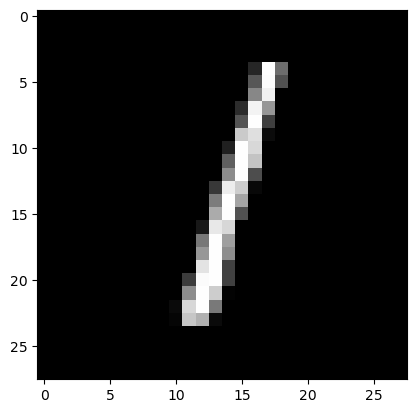

In [4]:
fig = plt.imshow(df['pixels'][2].reshape(28,28), cmap='gray')

## Dimensionality reduction

In this section we will think about how to distinguish the characteristics of different handwritten digits, starting only from the raw values of the pixels as features.

Let's consider 3 digits. Keep them as they are for the moment, you will have time at the end to play with these parameters.

In [5]:
## Digits considered here ##
labels = [1,6,8]
colors = ['red', 'blue', 'green']

X = np.array([df['pixels'][i] for i in df.index if df['label'][i] in labels])
y = np.array([df['label'][i] for i in df.index if df['label'][i] in labels])

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X shape: (3067, 784)
y shape: (3067,)


We have 28 x 28 = 784 features. It is a high dimension (~ same order of magnitude as the number of points). 

<div class="alert alert-warning">
Question: How would you visualize the behavior of the different classes (digits), or find a direction, important features contributing to these classes?
</div>

In this case, we cannot rely on univariate analysis: it is quite clear that the value of a given pixel on the image will not determine by itself the number which is written. You need to study the relationship between the pixel values: let's see how the methods to reduce dimensionality we saw during this course can help us distinguish noise, correlation and information patterns!

#### Principal Components Analysis: linear approach

In [6]:
from sklearn.decomposition import PCA

In [7]:
## Computing the PCA
pca = PCA(n_components=X.shape[1])
XPCA = pca.fit_transform(X)

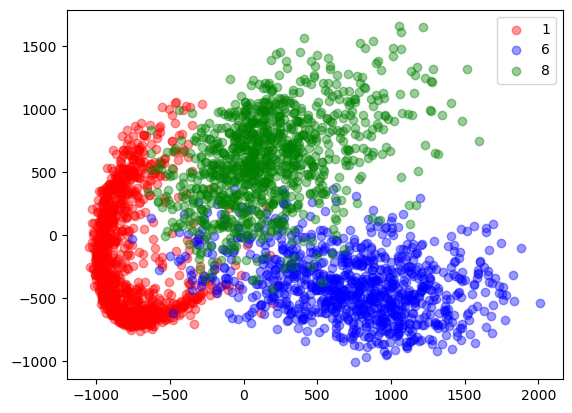

In [13]:
## Choose the axes you want to visualize
component_x = 1
component_y = 2

## Plotting
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.scatter(XPCA[y == labels[i],component_x-1], XPCA[y == labels[i],component_y-1], c=colors[i], label=labels[i], alpha=0.4)

l = ax.legend()

<div class="alert alert-warning">
Question: Try to visualize different axes and find the ones who allow (or not) to distinguish the classes.
</div>

#### t-distributed Stochastic Neighbor Embedding: non-linear approach

In [9]:
from sklearn.manifold import TSNE

In [33]:
## Computing the t-SNE 2D projection

## Parameters with real influence on the accuracy
perplexity = 30
# perplexity = 1000
learning_rate = 200
# learning_rate = 200
# learning_rate = "auto"
n_iter = 1000

# tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init="pca")
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
XTSNE = tsne.fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/jupyter-arm-tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


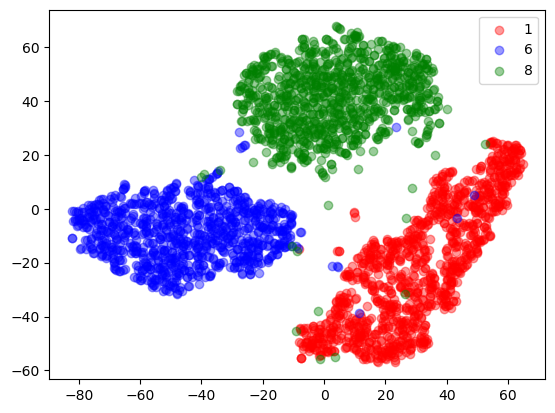

In [34]:
## Plotting
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.scatter(XTSNE[y == labels[i],0], XTSNE[y == labels[i],1], c=colors[i], label=labels[i], alpha=0.4)
l = ax.legend()

<div class="alert alert-warning">
Question: Try to visualize the projection by choosing different parameter values. What is the advantage of t-SNE over PCA? What is the inconvenient?
</div>

Inconvenient : pas d'explicabilité car les clusters se font par descente de gradiant.
<br>Avantage : meilleurs résultats

## Impact on supervised model performance

In this section, we consider a supervised Machine Learning model to predict the class of an image (which digit it corresponds to). We will study the impact of dimensionality reduction on 3 classifiers which have different mechanisms:
- Naive Bayes Classifier (nb)
- SVM Classifier (svm)
- Random Forest Classifier (rf)

We can give them as features 3 different inputs:
- All the pixel values (raw)
- The n first PCA components (10 for example)
- The 2 dimensions from t-SNE projection (tsne)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [36]:
def fit_my_model(model, features, test_size):
    
    ## Building train and test sets from features
    if features == 'raw':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    elif features == 'tsne':
        X_train, X_test, y_train, y_test = train_test_split(XTSNE, y, test_size=test_size)
    else:
        X_train, X_test, y_train, y_test = train_test_split(XPCA[:,:features], y, test_size=test_size)

    print("Training samples: "+str(X_train.shape[0]))
    print("Testing samples: "+str(X_test.shape[0]))
    print("Number of features: "+str(X_train.shape[1]))
    
    ## Fitting model
    if model == 'nb':
        clf = GaussianNB()
    elif model == 'svm':
        clf = SVC(gamma='auto')
    elif model == 'rf':
        clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features=np.min([10, X_train.shape[1]]))

    clf.fit(X_train, y_train)
    
    ## Printing scores
    learningScore = clf.score(X_train, y_train)
    generalizationScore = clf.score(X_test, y_test)
    print('Learning score: '+str(learningScore))
    print('Generalization score: '+str(generalizationScore))
    
    return generalizationScore

<div class="alert alert-warning">
Question: Experiment in the cell below by using the function fit_my_model, to check the scores for different configurations
</div>

In [37]:
model = 'svm' ## svm, nb, rf
features = 'raw' ## raw, tsne, or Integer corresponding to the n first PCA components
test_size = 0.2

score = fit_my_model(model, features, test_size)

Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.3697068403908795


<div class="alert alert-warning">
Question: What is the effect of dimensionality reduction on the 3 classifiers? Try to explain why with your intuition...
</div>

Let's test all the configurations and build a result table with test scores, to help you answer this question.

In [38]:
comparison_table = pd.DataFrame(columns = ['raw', 'pca', 'tsne'], index=['svm', 'nb', 'rf'])
for f in comparison_table.columns:
    for m in comparison_table.index:
        print(f + ' - ' + m)
        comparison_table.loc[m,f] = fit_my_model(m, f if f!='pca' else 10, 0.2)

raw - svm
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.3729641693811075
raw - nb
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 0.8980839788014676
Generalization score: 0.8908794788273615
raw - rf
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.993485342019544
pca - svm
Training samples: 2453
Testing samples: 614
Number of features: 10
Learning score: 1.0
Generalization score: 0.38273615635179153
pca - nb
Training samples: 2453
Testing samples: 614
Number of features: 10
Learning score: 0.9571952710966164
Generalization score: 0.9527687296416938
pca - rf
Training samples: 2453
Testing samples: 614
Number of features: 10
Learning score: 1.0
Generalization score: 0.9771986970684039
tsne - svm
Training samples: 2453
Testing samples: 614
Number of features: 2
Learning score: 0.9991846718304117
Generalization score: 0.9723127

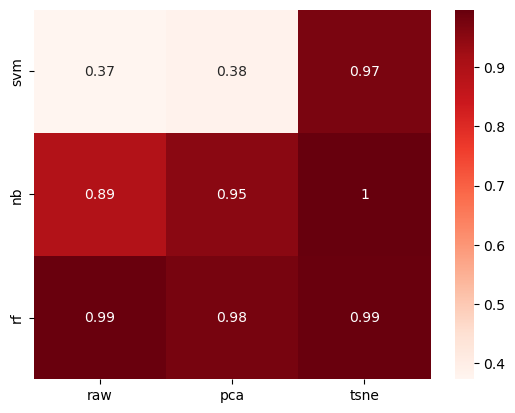

In [39]:
## Heatmap with summarized results
fig = sns.heatmap(comparison_table.astype('float'), annot=True, cmap='Reds')

<div class="alert alert-warning">
Question: What conclusions can you give? If you have time left, you can try with different sets of digits.
</div>

These examples concern supervised classifiers only. Can you imagine the impact on other tasks: regression, clustering, anomaly detection... ?

## Autoencoders

In this section we will build step by step an Autoencoder architecture, train it and evaluate it on MNIST data. First, it will be a standard fully connected autoencoder, then a variational autoencoder in the next section.

To prepare this work, let's import the appropriate libraries and use the full MNIST dataset from Keras, as Neural Networks will need more data for training.

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [41]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = np.array([x.flatten() for x in X_train]).astype("float32") / 255.
X_test = np.array([x.flatten() for x in X_test]).astype("float32") / 255.
print(X_train.shape)
print(X_test.shape)

11490434/11490434 [==============================] - 4s 0us/step
(60000, 784)
(10000, 784)


In this case we have normalized the pixel values between 0 and 1, to help neural network modelling (sigmoid) and training.

### Standard Autoencoder

In this first part, let's implement a standard autoencoder (fully-connected) with 1 hidden layer (200 units, ReLU activation) before the latent space (10 units, ReLU activation). Let's begin with the separate architectures for encoder and decoder. Be careful with the final layer activation!

In [42]:
###### CODE HERE ######

# Encoder architecture
encoder_inputs = keras.Input(shape=(784,))
hidden1 = layers.Dense(200, activation="relu")(encoder_inputs)
latent_space = layers.Dense(10, activation="relu")(hidden1)

encoder = keras.Model(encoder_inputs, latent_space, name="encoder")
#######################

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-05 16:13:28.855896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-05 16:13:28.856512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [43]:
###### CODE HERE ######

# Decoder architecture
decoder_inputs = keras.Input(shape=(10,))
hidden2 = layers.Dense(200, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(784, activation="sigmoid")(hidden2)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
#######################

Now, we combine them to build the full autoencoder.

In [44]:
# Combining architectures
outputs = decoder(latent_space)
autoencoder = keras.Model(encoder_inputs, outputs, name="autoencoder")

In [45]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 200)               157000    
                                                                 
 dense_1 (Dense)             (None, 10)                2010      
                                                                 
 decoder (Functional)        (None, 784)               159784    
                                                                 
Total params: 318,794
Trainable params: 318,794
Non-trainable params: 0
_________________________________________________________________


Now we need to define the loss function for training. In the case of MNIST images, we can use a pixelwise binary cross-entropy, summed up over the image. We could also use a mean squared error, let's leave it as an exercise.

In [46]:
# Loss function definition
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs) * 784

autoencoder_loss = K.mean(reconstruction_loss)

In [47]:
# Compiling the model
autoencoder.add_loss(autoencoder_loss)
autoencoder.compile(optimizer="adam")

In [48]:
###### CODE HERE ######

# Fitting the model
history = autoencoder.fit(X_train, X_train,
          epochs=30,
          batch_size=128,
          shuffle=True,
          validation_data=(X_test, X_test))

#######################

Epoch 1/30


2022-12-05 16:14:05.457493: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-05 16:14:05.796430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 151.5348

2022-12-05 16:14:10.610902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 5s 8ms/step - loss: 151.5348 - val_loss: 111.6597
Epoch 2/30
469/469 [==============================] - 3s 7ms/step - loss: 108.1898 - val_loss: 103.6746
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 102.4935 - val_loss: 99.5514
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 99.1332 - val_loss: 96.8464
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 96.8697 - val_loss: 94.9849
Epoch 6/30
469/469 [==============================] - 3s 7ms/step - loss: 95.1974 - val_loss: 93.5332
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 93.8116 - val_loss: 92.1861
Epoch 8/30
469/469 [==============================] - 4s 7ms/step - loss: 92.8010 - val_loss: 91.4919
Epoch 9/30
469/469 [==============================] - 3s 7ms/step - loss: 91.8972 - val_loss: 90.6954
Epoch 10/30
469/469 [==============================] - 3s 7ms/step - loss: 91.1482 - val

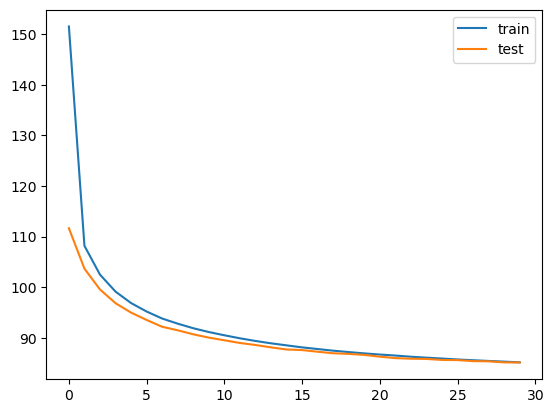

In [49]:
# Visualizing the training and validation losses
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

We seem to obtain a pretty reasonable training process! Let's visualize the quality of reconstructed images.

1/1 [==============================] - 0s 10ms/step


2022-12-05 16:15:43.610335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 16:15:43.688406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


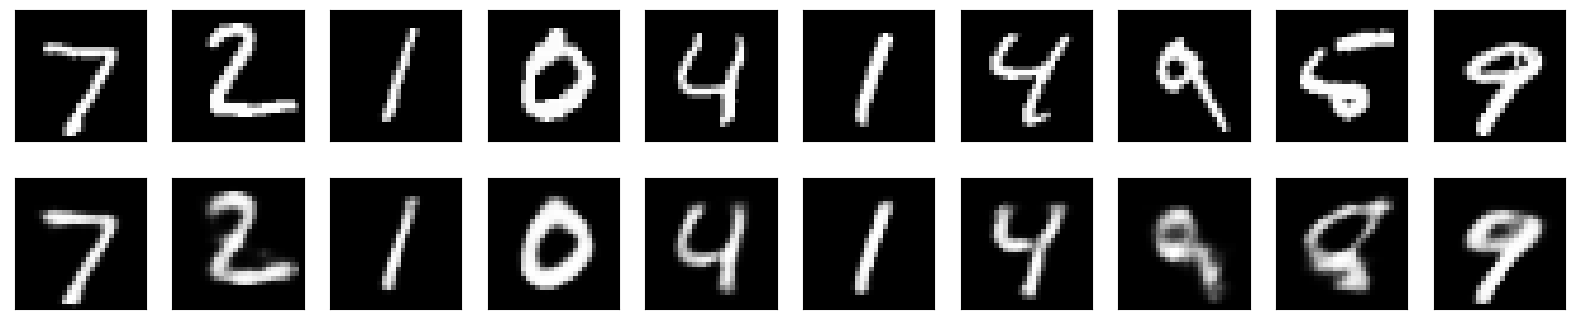

In [50]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    encoded_img = encoder.predict(np.array([X_test[i]]).reshape(1,784))
    decoded_img = decoder.predict(encoded_img).reshape(28, 28)
    plt.imshow(decoded_img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

We can see that some details are lost, but the global shapes are correctly reconstructed.

### Variational Autoencoder

In this second part, let's implement a variational autoencoder. Let's begin by defining the specific layer we will use to sample values from the gaussian distribution defined by the latent space means and standard deviations (z_mean, z_logvar).

In [51]:
###### CODE HERE ######

# Coding the specific sampling layer as a Keras Layer object
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_logvar = inputs

        nbatch = K.shape(z_mean)[0]
        ndim = K.shape(z_mean)[1]

        std = K.exp(z_logvar)
        eps = K.random_normal(shape=(nbatch,ndim), mean=0., stddev=0.1) 
        # epsilon
        
        z = z_mean + eps * std

        return z

#######################

Let's write now the separate encoder and decoder architectures. Be careful, no activation function for mean and logvar computation...

In [52]:
###### CODE HERE ######

# Encoder architecture
encoder_inputs = keras.Input(shape=(784,))
hidden1 = layers.Dense(200, activation="relu")(encoder_inputs)

z_mean = layers.Dense(10)(hidden1)
z_logvar = layers.Dense(10)(hidden1)

# Sampling
z = Sampling()([z_mean, z_logvar])

encoder = keras.Model(encoder_inputs, z, name="encoder")

#######################

In [53]:
# Decoder architecture
decoder_inputs = keras.Input(shape=(10,))
decoder_hidden = layers.Dense(200, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(784, activation="sigmoid")(decoder_hidden)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

Now, we combine them to build the full autoencoder.

In [54]:
# Combining architectures
outputs = decoder(z)
vae = keras.Model(encoder_inputs, outputs, name="vae")

In [55]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 200)          157000      ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 10)           2010        ['dense_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 10)           2010        ['dense_4[0][0]']                
                                                                                                

Now we need to define the loss function for training. As reconstruction loss, we can still use the pixelwise binary cross-entropy, summed up over the image. In the case of VAE, there is an additional term to the loss: the Kullback-Leibler divergence. Write this new term, using the keras backend functions: K.square, K.exp, K.sum...

In [56]:
###### CODE HERE ######

# Loss function definition
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs) * 784

kl_loss = -0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar))

vae_loss = K.mean(reconstruction_loss + kl_loss)

#######################

In [57]:
# Compiling the model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [58]:
# Fitting the model
history = vae.fit(X_train, X_train,
          epochs=30,
          batch_size=128,
          shuffle=True,
          validation_data=(X_test, X_test))

Epoch 1/30


2022-12-05 16:23:05.122485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 241.3536

2022-12-05 16:23:09.501298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 5s 9ms/step - loss: 241.3536 - val_loss: 198.2674
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 189.0821 - val_loss: 178.9544
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 174.2473 - val_loss: 169.0247
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 166.9890 - val_loss: 164.2327
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 162.8904 - val_loss: 159.6493
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 158.9382 - val_loss: 156.3441
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 156.1751 - val_loss: 153.8990
Epoch 8/30
469/469 [==============================] - 4s 8ms/step - loss: 154.0000 - val_loss: 151.9349
Epoch 9/30
469/469 [==============================] - 4s 8ms/step - loss: 152.3065 - val_loss: 150.7006
Epoch 10/30
469/469 [==============================] - 4s 8ms/step - loss: 

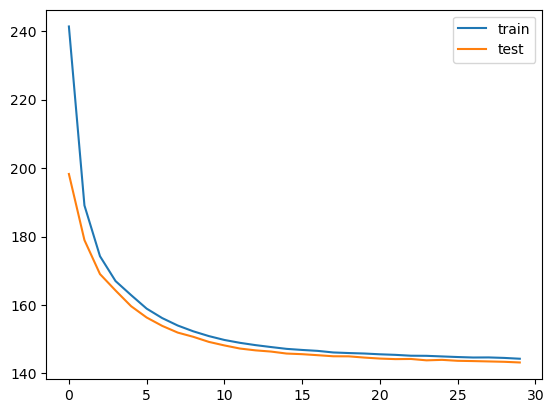

In [59]:
# Visualizing the training and validation losses
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

We seem to obtain a pretty reasonable training process! Let's visualize the quality of reconstructed images.

1/1 [==============================] - 0s 192ms/step


2022-12-05 16:25:03.236635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


2022-12-05 16:25:03.441123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


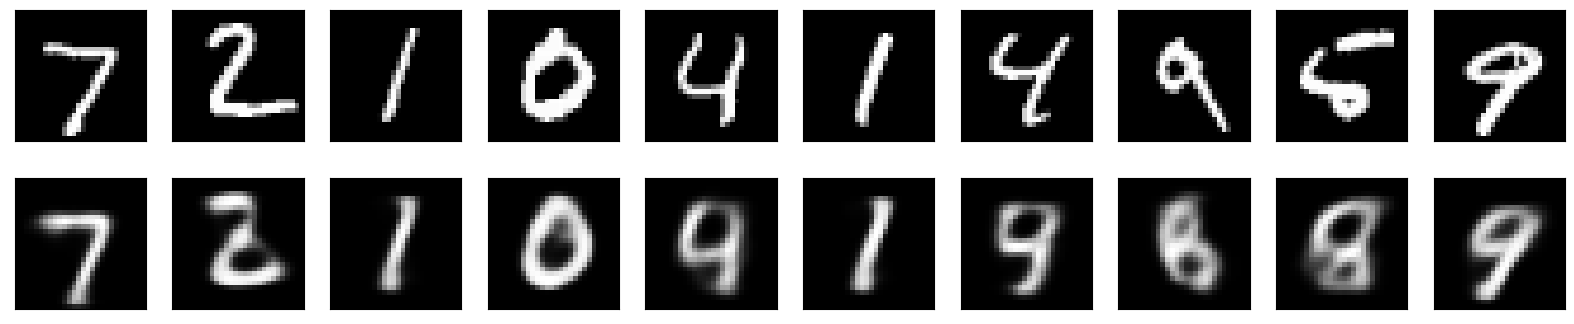

In [60]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    encoded_img = encoder.predict(np.array([X_test[i]]).reshape(1,784))
    decoded_img = decoder.predict(encoded_img).reshape(28, 28)
    plt.imshow(decoded_img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

We can see that some details are lost, but the global shapes are correctly reconstructed.

Since a VAE uses a generative model, we can use the decoder to build fake images, and we can see that the latent space is continuous! Let's sample some random images in a given range of latent space values.

1/1 [==============================] - 0s 10ms/step


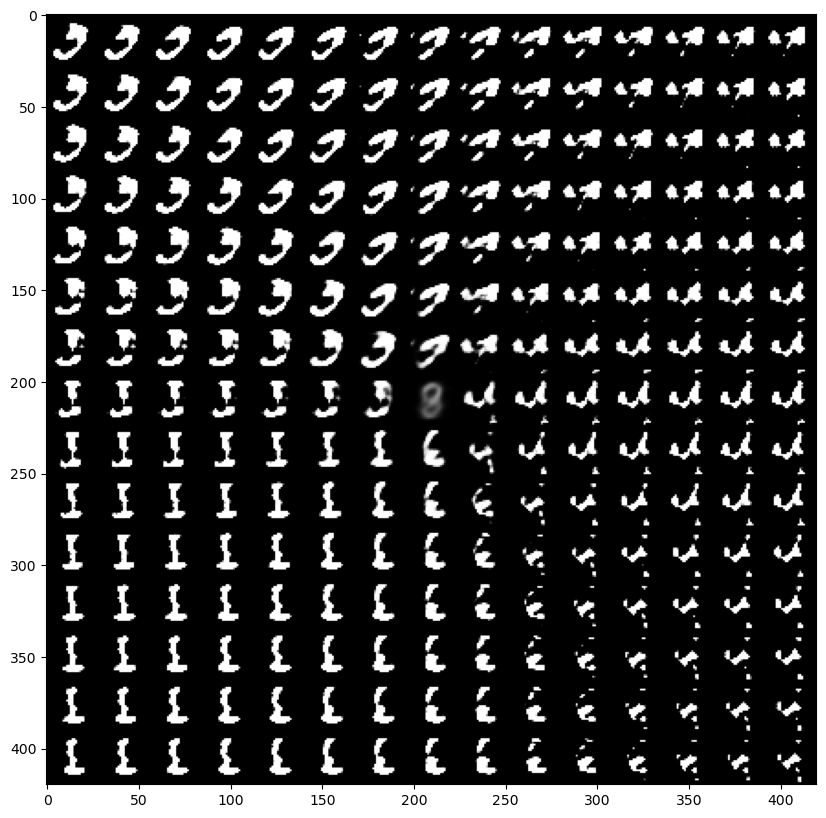

In [61]:
n = 15  # figure with 15x15 generated images
figure = np.zeros((28 * n, 28 * n))

# We sample n images within [-15, 15] standard deviations, around 0 mean
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # We sample the latent space over the 2 first neurons, feel free to change that to other pairs!
        z_sample = np.array([[xi, yi, 0, 0, 0, 0, 0, 0, 0, 0]])
        x_decoded = decoder.predict(z_sample)

        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.show()

<div class="alert alert-warning">
Exercise: if you had to detect an abnormal image (for example: not a digit) in this 1D dataset, how would you do?
</div>

Try to introduce a gray-scale 28x28 image of your choice in the dataset (picture of your cat...). Shuffle the dataset, and test your anomaly detection method to find it!

## Conclusion

Always think first about the principles, the intuition, the qualitative aspect behind all the available functions you can find online.

- Many people can chain very complex algorithms together and get results which might be relevant for a problem.
- Only a few can make the right choices to quickly optimize the resolution of a problem and assess its feasability...